In [1]:
import os, time, math, csv, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
pd.options.display.float_format = '{:.2f}'.format

In [2]:
data_path=os.getcwd()+"/ANN_dataset/modifiedData/GD/GD_mod"
output_data_path=os.getcwd()+"/ANN_dataset/modifiedData/GD/input_data_model"
model_path=os.getcwd()+"/models"
distances=list(range(1,25))
print(distances)
ns=25 # number of samples
centers=[[-3,3],[-1,3],[1,3],[3,3],[-3,1],[-1,1],[1,1],[3,1],[-3,-1],[-1,-1],[1,-1],[3,-1],[-3,-3],[-1,-3],[1,-3],[3,-3]]
selCP=[1,7,10,15]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [3]:
def L2dist(a,b):
    return math.sqrt(math.pow(a[0]-b[0],2)+math.pow(a[1]-b[1],2))

In [4]:
F=[]
pref="consts_modified_source_distance_"
suf="_alpha_75_beta_25.csv"
for ll in distances:
    s_id=0
    source=ll*80
    print("Source: ", source)
    filename=data_path+"/"+pref+str(source)+suf
    df = pd.read_csv(filename)
    for hh in range(ll+1,26):
        target=hh*80
        print("\tTarget: ", target)
        df_sel=df[df["Target_Distance"]==target]
        for i in range(1,ns+1):
            s_id+=1
            df_aux=df_sel[df_sel["Sample_Id"]==s_id]
            real=list(df_aux["Real"])
            imag=list(df_aux["Imag"])
            data_aux=list(zip(real,imag))
            gmm = GaussianMixture(n_components=16, random_state=0, init_params='kmeans', means_init=centers).fit(data_aux)
            mus=gmm.means_
            sigmas=gmm.covariances_
            features=[source,target]
            for jj in selCP:
                j=centers[jj-1]
                mindist=None
                k_inc=None
                for k in range(16):
                    d=L2dist(mus[k],j)
                    if mindist is None or mindist>d:
                        mindist=d
                        k_inc=k
                covmat=np.concatenate(list(sigmas[k_inc])).ravel().tolist()
                features = [*features, *mus[k_inc], *covmat]
            F.append(features)   

Source:  80
	Target:  160
	Target:  240
	Target:  320
	Target:  400
	Target:  480
	Target:  560
	Target:  640
	Target:  720
	Target:  800
	Target:  880
	Target:  960
	Target:  1040
	Target:  1120
	Target:  1200
	Target:  1280
	Target:  1360
	Target:  1440
	Target:  1520
	Target:  1600
	Target:  1680
	Target:  1760
	Target:  1840
	Target:  1920
	Target:  2000
Source:  160
	Target:  240
	Target:  320
	Target:  400
	Target:  480
	Target:  560
	Target:  640
	Target:  720
	Target:  800
	Target:  880
	Target:  960
	Target:  1040
	Target:  1120
	Target:  1200
	Target:  1280
	Target:  1360
	Target:  1440
	Target:  1520
	Target:  1600
	Target:  1680
	Target:  1760
	Target:  1840
	Target:  1920
	Target:  2000
Source:  240
	Target:  320
	Target:  400
	Target:  480
	Target:  560
	Target:  640
	Target:  720
	Target:  800
	Target:  880
	Target:  960
	Target:  1040
	Target:  1120
	Target:  1200
	Target:  1280
	Target:  1360
	Target:  1440
	Target:  1520
	Target:  1600
	Target:  1680
	Target:  1760
	T

In [5]:
header=['source','target']
for j in selCP:
    header=[*header,*['mu_r_'+str(j),'mu_i_'+str(j),'sigma_rr_'+str(j),'sigma_ri_'+str(j),'sigma_ir_'+str(j),'sigma_ii_'+str(j)]]
    
DF_testing=pd.DataFrame(F)
DF_testing.columns=header
DF_testing.to_csv(output_data_path+'/testing_data_DNN.csv', index=False)

#continue hereafter

In [6]:

df=pd.read_csv(output_data_path+'/testing_data_DNN.csv')

colnames=df.columns[2:26]
# Target variable and train set
X=df.iloc[:,2:26]
#print(X.shape)
#print(X.columns)
Y=df.iloc[:,1].to_numpy().reshape(-1,1)
Z=df.iloc[:,0].to_numpy().reshape(-1,1)
#print(Y.shape)
#print(Y.columns)

#labels=[int(i) for i in df.iloc[:,0]]



In [7]:
from keras.models import model_from_json

model_ann = model_from_json(open(model_path+'/model_ann_architecture.json').read())
model_ann.load_weights(model_path+'/model_ann_weights.h5')
# dont forget to compile your model
model_ann.compile(loss='binary_crossentropy', optimizer='adam')
sc_input=joblib.load(model_path+'/scaler_input.joblib')
sc_output=joblib.load(model_path+'/scaler_output.joblib')


In [8]:
df=DF_testing
colnames=df.columns[1:25]
X_test = sc_input.transform(X)
Y_test = sc_output.transform(Y)

In [9]:
Z=[i[0] for i in Z]

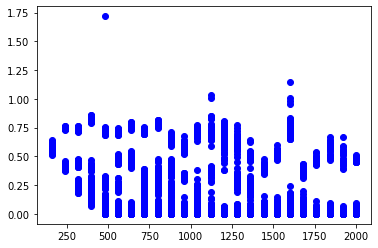

In [10]:
start_time = time.time()
Y_test_pred=model_ann.predict(X_test)
#Y_test_pred=model_ann.predict(X_test)
time_eval_ann=time.time()-start_time

real=list(list(zip(*Y_test))[0])

#real=list(map(list, zip(*Y_train)))
pred=list(Y_test_pred)

dist_min=sc_output.data_min_[0]
dist_max=sc_output.data_max_[0]

real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real))
real_abs=[int(np.round(i)) for i in real_abs]
#print(real_abs)
pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred))
#pred_abs=sum(pred_abs, [])
pred_abs=[i[0] for i in pred_abs]

error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))

res=pd.DataFrame({"source":Z, "target":real_abs,"pred":pred_abs,"error":error})


plt.plot(real_abs,error,'bo')
plt.show()

In [11]:
F=pd.read_csv(model_path+"/reference.csv")
k=4

In [12]:
one_classifier={}
for i in range(25):
    row=F.iloc[i,]
    one_classifier[row["dist"]]=[row["mean"]-k*row["std"],row["mean"]+k*row["std"]]

In [13]:
aux=[]
for i in range(res.shape[0]):
    target=res.iloc[i,]["target"]
    pred=res.iloc[i,]["pred"]
    if pred>=one_classifier[target][0] and pred<=one_classifier[target][1]:
        aux.append(0)
    else:
        aux.append(1)
res["detected"]=aux
print(res)
res.to_csv(output_data_path+"/results.csv",index=False)


      source  target    pred  error  detected
0         80     160   73.93   0.54         1
1         80     160   71.72   0.55         1
2         80     160   71.70   0.55         1
3         80     160   69.17   0.57         1
4         80     160   72.09   0.55         1
5         80     160   72.34   0.55         1
6         80     160   77.38   0.52         1
7         80     160   67.00   0.58         1
8         80     160   73.79   0.54         1
9         80     160   65.46   0.59         1
10        80     160   69.52   0.57         1
11        80     160   70.67   0.56         1
12        80     160   71.72   0.55         1
13        80     160   69.26   0.57         1
14        80     160   60.66   0.62         1
15        80     160   70.52   0.56         1
16        80     160   72.17   0.55         1
17        80     160   61.39   0.62         1
18        80     160   64.24   0.60         1
19        80     160   72.64   0.55         1
20        80     160   57.66   0.6